In [1]:
from std_methods import std_methods

tickers = ['AAPL','JPM','F','PG', 'BA']

equal_weights,min_risk,risk_parity = std_methods(tickers,'1992-01-01','2022-18-31','2023-01-01','2023-12-31')

[7.95985831e-12 3.45395956e-11 9.47447097e-01 5.09396416e-02
 1.61326095e-03]
[0.02270654 0.0285299  0.9138212  0.03045487 0.00448748]


In [2]:
import matplotlib.pyplot as plt
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.vec_env import VecEnv
import numpy as np

investment_period = 1 # each 1 investment days 
reward_period = 15 # each 15 investment periods

def evaluate_model(model:BaseAlgorithm,env:VecEnv):
    done = False
    rewards = []
    portfolio_worths = []
    obs = env.reset()
    portfolio_worths.append(1.0)
    while not done:
        action, _states = model.predict(obs,deterministic=True)
        obs, reward, done,info = env.step(action)
        portfolio_worths.append(info[0]['porfolio_worth'])
        rewards.append(reward)
    return np.array(rewards),np.array(portfolio_worths)

d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.67GB
  warnings.warn(


paper Sharpe Ratio: 0.0660169351874154,  Information Ratio: -0.18598381195932664


d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.67GB
  warnings.warn(


max gain 0.5 Sharpe Ratio: 0.513832354337203,  Information Ratio: 0.5768280734196737


d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.66GB
  warnings.warn(


max gain 0.75 Sharpe Ratio: 0.2665784415958148,  Information Ratio: 0.1286252484406856
max gain 1 Sharpe Ratio: 0.2643329185643364,  Information Ratio: 0.15782872862424643


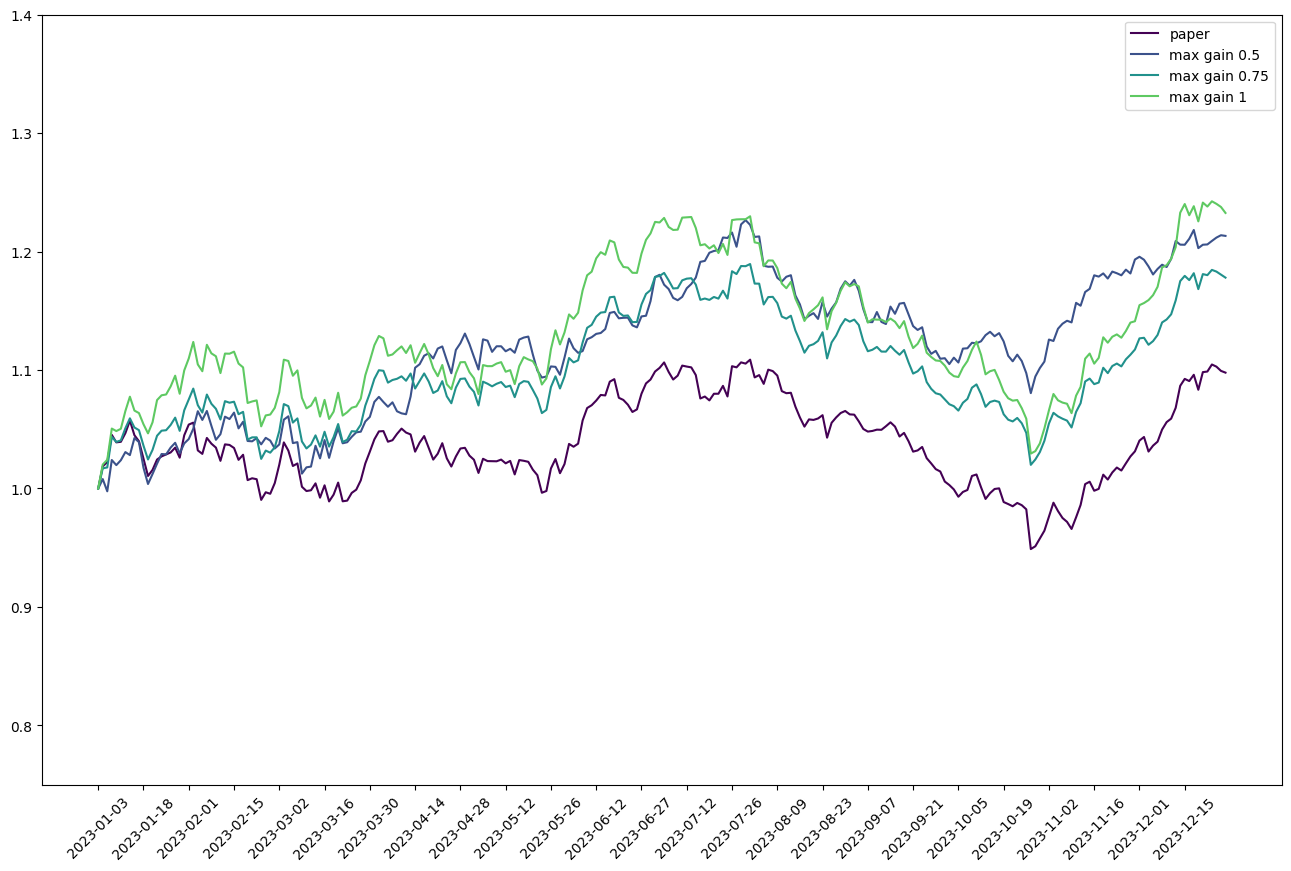

In [3]:
from stable_baselines3 import SAC
from DSAC import DSAC
from enviroments.benchmark import create_env_benchmark

eval_env,eval_dates,eval_benchmark,prices = create_env_benchmark(tickers,'2023-01-01','2023-12-31',investment_period,reward_period)

models = {
    'paper': 'SAC_bm_djia_inv_1_rew_15',
    'max gain 0.5': 'SAC_mg_risk_0.5_inv_1_rew_15',
    'max gain 0.75': 'SAC_mg_risk_0.75_inv_1_rew_15',
    'max gain 1': 'SAC_mg_risk_1_inv_1_rew_15',
}

plt.figure(figsize=(16,10))
i = 0
# find sharpe ratio and information ratio for each model
for model_name,model_path in models.items():
    if model_path.startswith('SAC'):
        model = SAC.load(f'./models/{model_path}.zip')
    elif model_path.startswith('DSAC'):
        model = DSAC.load(f'./models/{model_path}.zip')
        
    rewards,portfolio_worths = evaluate_model(model,eval_env)
    plt.plot(eval_dates,portfolio_worths, linestyle='-',label=f'{model_name}', color = plt.cm.viridis(i/len(models)))
    
    # take monthly returns
    monthly_portfolio_worths = portfolio_worths[::25]
    monthly_portfolio_returns = np.diff(monthly_portfolio_worths)/monthly_portfolio_worths[:-1]
    # calculate sharpe ratio
    sharpe_ratio = np.mean(monthly_portfolio_returns)/np.std(monthly_portfolio_returns)
    
    # calculate information ratio
    monthly_benchmark_worths = eval_benchmark[::25]
    monthly_benchmark_returns = np.diff(monthly_benchmark_worths)/monthly_benchmark_worths[:-1]
    excess_returns = monthly_portfolio_returns - monthly_benchmark_returns
    information_ratio = np.mean(excess_returns)/np.std(excess_returns)
    i += 1
    print(f'{model_name} Sharpe Ratio: {sharpe_ratio},  Information Ratio: {information_ratio}')
    
# eval_benchmark_relative = eval_benchmark/eval_benchmark[0]
# plt.plot(eval_dates,eval_benchmark_relative,linestyle='-',label='Benchmark', color='black')

# plt.plot(eval_dates,min_risk,linestyle='-',label='Min Risk', color='red')
# plt.plot(eval_dates,risk_parity,linestyle='-',label='Risk Parity', color='blue')

plt.xticks(eval_dates[::(len(eval_dates)//25)],rotation=45)
plt.ylim(0.75,1.4)
plt.legend()